In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import xgboost as xgb
from num2words import num2words
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
sns.set(style='whitegrid')


In [107]:
engine = 'sqlite:///drafts1.db'
df = pd.read_sql('SELECT * FROM drafts', engine)
print(f"Loaded {len(df)} records")

Loaded 560 records


In [108]:
for col in ['bank','place_created','drawer_name','payer_name_address','amount_words']:
    df[col] = df[col].astype(str).str.strip()
for col in ['date_created','date_due']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df['amount_digits'] = pd.to_numeric(df['amount_digits'], errors='coerce')
df = df.dropna(subset=['amount_digits','date_created','date_due','rib'])
df['gap_days'] = (df['date_due'] - df['date_created']).dt.days
# keep realistic range
max_gap = df['gap_days'].quantile(0.99)
df = df[(df['gap_days'] >= 0) & (df['gap_days'] <= max_gap)]
df['fraud_label'] = df['fraud_label'].astype(int)
df = df.drop_duplicates()

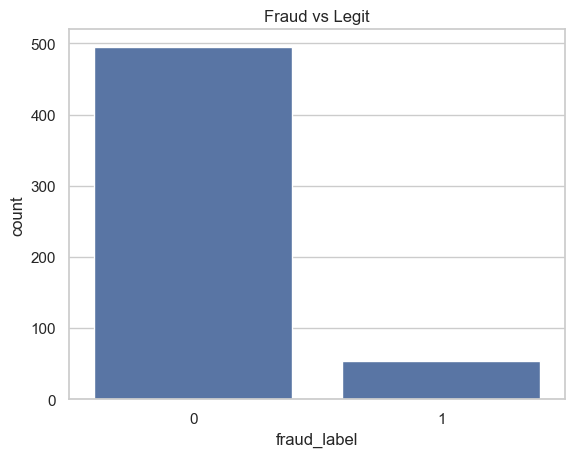

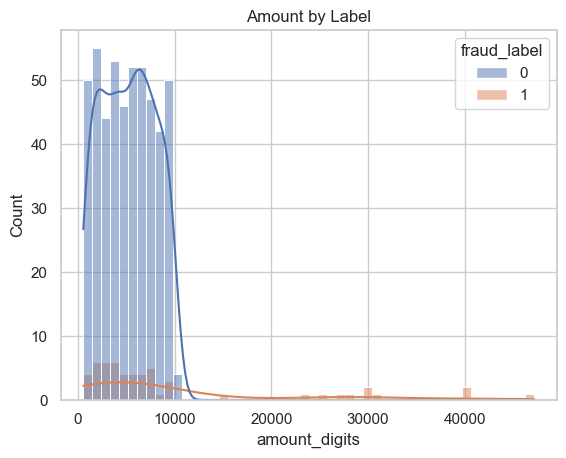

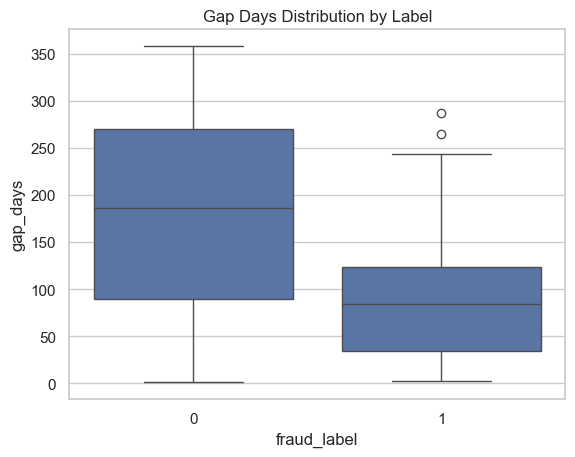

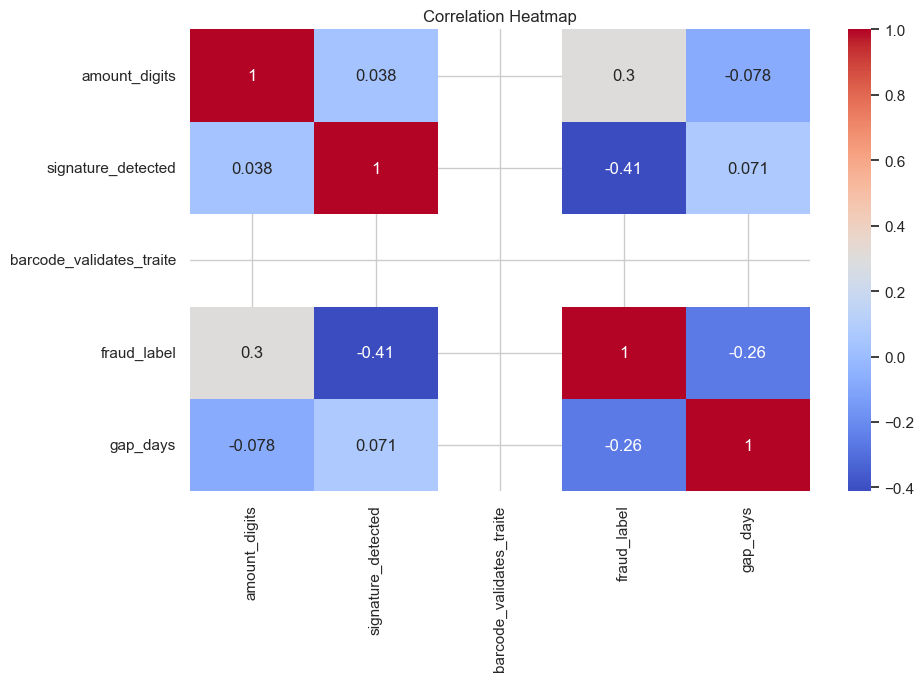

In [109]:
# Fraud count
sns.countplot(x='fraud_label', data=df)
plt.title('Fraud vs Legit'); plt.show()

# Amount distribution by label
sns.histplot(df, x='amount_digits', hue='fraud_label', bins=50, kde=True)
plt.title('Amount by Label'); plt.show()

# Distribution of gap_days
sns.boxplot(x='fraud_label', y='gap_days', data=df)
plt.title('Gap Days Distribution by Label'); plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap'); plt.show()

In [110]:
def amount_to_words_fr(x):
    return num2words(x, lang='fr').replace('virgule','virgule')

def is_valid_rib(v):
    s = ''.join(filter(str.isdigit, str(v)))
    if len(s) != 20:
        return False
    try:
        n = int(s[:-2] + '00')
        chk = 97 - (n % 97)
        return chk == int(s[-2:])
    except:
        return False

In [111]:
fdf = df.copy()
fdf['words_match'] = (fdf['amount_words'] == fdf['amount_digits'].apply(amount_to_words_fr)).astype(int)
fdf['sig_missing'] = (~fdf['signature_detected']).astype(int)
fdf['barcode_bad'] = (~fdf['barcode_validates_traite']).astype(int)
fdf['rib_invalid'] = (~fdf['rib'].apply(is_valid_rib)).astype(int)
fdf['payer_len'] = fdf['payer_name_address'].str.len()
fdf['drawer_len'] = fdf['drawer_name'].str.len()

features = ['amount_digits','gap_days','words_match','sig_missing','barcode_bad','rib_invalid','payer_len','drawer_len']
X = fdf[features].values
y = fdf['fraud_label'].values

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y,random_state=42)

In [113]:
scale_pos = np.bincount(y_train)[0] / np.bincount(y_train)[1]
sm = SMOTE(sampling_strategy=0.3, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(f"Resampled training set: {len(y_res)} entries, {y_res.sum()} frauds")

Resampled training set: 514 entries, 118 frauds


In [114]:
def evaluate_thresholds(model, X, y):
    # cross-validated probabilities
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    probs_cv = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:,1]
    # ROC AUC
    print("CV ROC AUC:", roc_auc_score(y, probs_cv))
    # Precision-Recall curve
    prec, rec, thr = precision_recall_curve(y, probs_cv)
    f1s = [f1_score(y, probs_cv > t) for t in thr]
    best_idx = np.argmax(f1s)
    return thr[best_idx]

In [115]:

model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [116]:
opt_threshold = evaluate_thresholds(model, X_res, y_res)
print("Optimal decision threshold from CV:", opt_threshold)

C:\Users\mghir\Desktop\layoutMl\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:43:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\mghir\Desktop\layoutMl\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:43:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


CV ROC AUC: 0.9551660674542031
Optimal decision threshold from CV: 0.76288974


In [117]:
model.fit(X_res, y_res)
joblib.dump(model, 'xgb_model.pkl')

C:\Users\mghir\Desktop\layoutMl\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [23:43:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['xgb_model.pkl']

In [118]:
probs_test = model.predict_proba(X_test)[:,1]
print("Test ROC AUC:", roc_auc_score(y_test, probs_test))

Test ROC AUC: 0.8264462809917356


              precision    recall  f1-score   support

           0       0.94      0.96      0.95        99
           1       0.56      0.45      0.50        11

    accuracy                           0.91       110
   macro avg       0.75      0.71      0.72       110
weighted avg       0.90      0.91      0.91       110



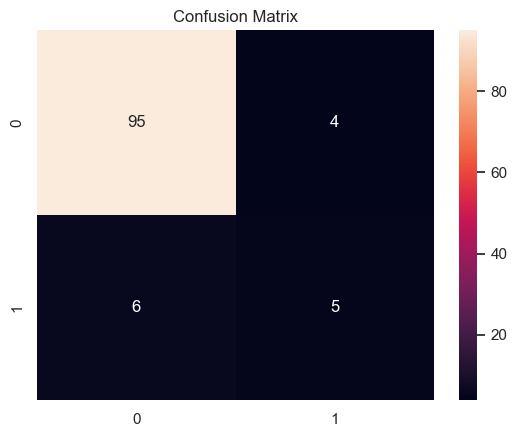

In [119]:
preds = (probs_test > opt_threshold).astype(int)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d')
plt.title('Confusion Matrix'); plt.show()

In [120]:
# prec,rec,thr = precision_recall_curve(y_test,probs)
# plt.plot(thr,prec[:-1],label='Precision'); plt.plot(thr,rec[:-1],label='Recall')
# plt.xlabel('Threshold');plt.legend();plt.title('Precision-Recall vs Threshold');plt.show()


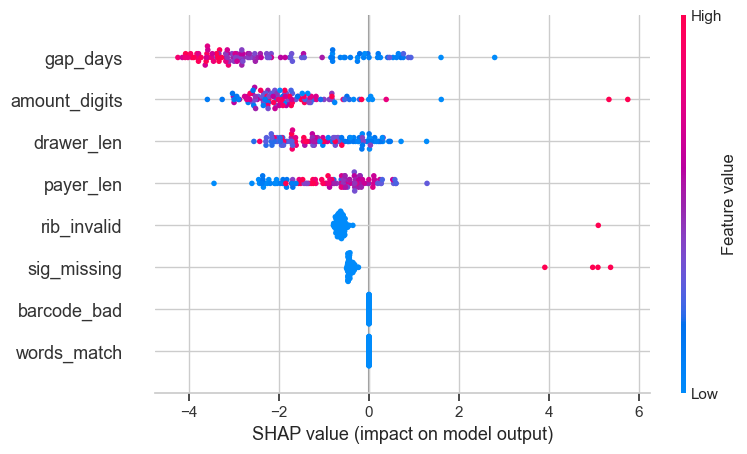

In [121]:

explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, feature_names=features)

In [122]:
import pandas as pd
import joblib
# Load once
_xgb = joblib.load('xgb_model.pkl')

In [123]:
def predict_xgb(raw_input, model, threshold=opt_threshold):
    gap = (pd.to_datetime(raw_input['date_due'])-pd.to_datetime(raw_input['date_created'])).days
    feat = [
        raw_input['amount_digits'], gap,
        int(raw_input['amount_words'] == amount_to_words_fr(raw_input['amount_digits'])),
        int(not raw_input['signature_detected']),
        int(not raw_input['barcode_validates_traite']),
        int(not is_valid_rib(raw_input['rib'])),
        len(raw_input['payer_name_address']),
        len(raw_input['drawer_name'])
    ]
    prob = model.predict_proba([feat])[0][1]
    return {'fraud_score': round(prob, 3), 'fraud_label': bool(prob > threshold)}

In [140]:
gen_example = lambda r: dict(
    date_created=r.date_created, date_due=r.date_due,
    amount_digits=float(r.amount_digits), amount_words=r.amount_words,
    signature_detected=bool(r.signature_detected),
    barcode_validates_traite=bool(r.barcode_validates_traite),
    rib=r.rib, payer_name_address=r.payer_name_address, drawer_name=r.drawer_name
)

legit = df[df.fraud_label == 0].sample(1).iloc[0]   # no seed
fraud = df[df.fraud_label == 1].sample(1).iloc[0]
print(fraud, legit)

print('Legit prediction:', predict_xgb(gen_example(legit), model))
print('Fraud prediction:', predict_xgb(gen_example(fraud), model))

traite_num                                                        97686304367
bank                                                          Hoareau Riou SA
amount_digits                                                        2300.702
amount_words                deux mille trois cents dinars zéro sept zéro deux
rib                                                      33533106005313122020
signature_detected                                                          0
barcode_validates_traite                                                    1
date_created                                              2024-09-06 00:00:00
date_due                                                  2025-03-26 00:00:00
place_created                                                Saint Antoinette
drawer_name                                           Vincent Blanchard-Hamon
payer_name_address                             boulevard Traore 89541 Leclerc
fraud_label                                                     